In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [30]:
df = pd.read_csv('hourly_summary.csv',parse_dates=['device_time'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   device_time     979 non-null    datetime64[ns]
 1   humidity        979 non-null    float64       
 2   temperature     979 non-null    float64       
 3   hour            979 non-null    int64         
 4   Temp_MA_2       978 non-null    float64       
 5   Humidity_MA_2   978 non-null    float64       
 6   Temp_rate       977 non-null    float64       
 7   Humidity_rate   977 non-null    float64       
 8   Temp_phase      979 non-null    object        
 9   Humidity_phase  979 non-null    object        
 10  daytime_labels  979 non-null    object        
 11  Temp_group      979 non-null    int64         
 12  Humidity_group  979 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(3)
memory usage: 99.6+ KB


In [32]:
df.head()

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels,Temp_group,Humidity_group
0,2025-10-05 00:00:00,81.0,27.0,0,NaN,NaN,NaN,NaN,Neutral,Moderate,late night,1,1
1,2025-10-05 01:00:00,81.3,27.0,1,27.0,81.15,NaN,NaN,Neutral,Moderate,late night,1,1
2,2025-10-05 02:00:00,81.6,27.0,2,27.0,81.45,0.0,0.30,Neutral,Moistening,late night,1,2
3,2025-10-05 03:00:00,81.8,27.0,3,27.0,81.70,0.0,0.25,Neutral,Moistening,late night,1,2
4,2025-10-05 04:00:00,82.0,27.0,4,27.0,81.90,0.0,0.20,Neutral,Moistening,early morning,1,2


In [33]:
df.head()

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels,Temp_group,Humidity_group
0,2025-10-05 00:00:00,81.0,27.0,0,NaN,NaN,NaN,NaN,Neutral,Moderate,late night,1,1
1,2025-10-05 01:00:00,81.3,27.0,1,27.0,81.15,NaN,NaN,Neutral,Moderate,late night,1,1
2,2025-10-05 02:00:00,81.6,27.0,2,27.0,81.45,0.0,0.30,Neutral,Moistening,late night,1,2
3,2025-10-05 03:00:00,81.8,27.0,3,27.0,81.70,0.0,0.25,Neutral,Moistening,late night,1,2
4,2025-10-05 04:00:00,82.0,27.0,4,27.0,81.90,0.0,0.20,Neutral,Moistening,early morning,1,2


In [34]:
df.corr(numeric_only=True)

,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_group,Humidity_group
humidity,1.000000,0.309314,-0.048009,0.298303,0.986076,0.093465,0.249452,-0.660722,-0.654228
temperature,0.309314,1.000000,-0.114363,0.987562,0.322210,0.247131,-0.021284,-0.308579,-0.296759
hour,-0.048009,-0.114363,1.000000,-0.119148,-0.059492,0.006026,0.126837,0.011421,0.011467
Temp_MA_2,0.298303,0.987562,-0.119148,1.000000,0.314090,0.125654,-0.056874,-0.312472,-0.300460
Humidity_MA_2,0.986076,0.322210,-0.059492,0.314090,1.000000,0.096297,0.131689,-0.668945,-0.662391
Temp_rate,0.093465,0.247131,0.006026,0.125654,0.096297,1.000000,0.135970,-0.003677,-0.003898
Humidity_rate,0.249452,-0.021284,0.126837,-0.056874,0.131689,0.135970,1.000000,-0.009614,-0.009149
Temp_group,-0.660722,-0.308579,0.011421,-0.312472,-0.668945,-0.003677,-0.009614,1.000000,0.999079
Humidity_group,-0.654228,-0.296759,0.011467,-0.300460,-0.662391,-0.003898,-0.009149,0.999079,1.000000


# Computing Previous (Hour) Features

In [35]:
df["humidity_lag1"] = df["humidity"].shift(1)
df["humidity_lag2"] = df["humidity"].shift(2)
df["humidity_lag3"] = df["humidity"].shift(3)
df['humidity_rate_lag1'] = df['Humidity_rate'].shift(1)
df["temp_lag1"] = df["temperature"].shift(1)

In [36]:
df.corr(numeric_only=True)

,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_group,Humidity_group,humidity_lag1,humidity_lag2,humidity_lag3,humidity_rate_lag1,temp_lag1
humidity,1.000000,0.309314,-0.048009,0.298303,0.986076,0.093465,0.249452,-0.660722,-0.654228,0.944559,0.884722,0.838291,0.229514,0.279536
temperature,0.309314,1.000000,-0.114363,0.987562,0.322210,0.247131,-0.021284,-0.308579,-0.296759,0.325802,0.321718,0.312185,0.033104,0.950545
hour,-0.048009,-0.114363,1.000000,-0.119148,-0.059492,0.006026,0.126837,0.011421,0.011467,-0.071498,-0.105089,-0.133863,0.136079,-0.120755
Temp_MA_2,0.298303,0.987562,-0.119148,1.000000,0.314090,0.125654,-0.056874,-0.312472,-0.300460,0.321136,0.327445,0.320549,0.006069,0.987555
Humidity_MA_2,0.986076,0.322210,-0.059492,0.314090,1.000000,0.096297,0.131689,-0.668945,-0.662391,0.986008,0.927388,0.873314,0.243591,0.298150
Temp_rate,0.093465,0.247131,0.006026,0.125654,0.096297,1.000000,0.135970,-0.003677,-0.003898,0.096438,0.028466,-0.024675,0.251911,0.001016
Humidity_rate,0.249452,-0.021284,0.126837,-0.056874,0.131689,0.135970,1.000000,-0.009614,-0.009149,0.009957,-0.230689,-0.210833,0.456718,-0.091058
Temp_group,-0.660722,-0.308579,0.011421,-0.312472,-0.668945,-0.003677,-0.009614,1.000000,0.999079,-0.659220,-0.657773,-0.656313,-0.009882,-0.308126
Humidity_group,-0.654228,-0.296759,0.011467,-0.300460,-0.662391,-0.003898,-0.009149,0.999079,1.000000,-0.652816,-0.651415,-0.649847,-0.009834,-0.296213
humidity_lag1,0.944559,0.325802,-0.071498,0.321136,0.986008,0.096438,0.009957,-0.659220,-0.652816,1.000000,0.944188,0.883916,0.250865,0.308477


In [37]:
training_data = df[['temp_lag1','humidity','humidity_lag1','hour']]

In [38]:
training_data = training_data.dropna()

In [39]:
training_data.corr()

,temp_lag1,humidity,humidity_lag1,hour
temp_lag1,1.000000,0.279536,0.308477,-0.120755
humidity,0.279536,1.000000,0.944559,-0.045855
humidity_lag1,0.308477,0.944559,1.000000,-0.071498
hour,-0.120755,-0.045855,-0.071498,1.000000


In [40]:
def get_distribution_type(data: pd.DataFrame, feature: str, **kwargs):
    """
    Plot the distribution of a given feature using seaborn.displot.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the feature.
    feature : str
        Column name to plot.
    **kwargs :
        Additional keyword arguments passed to sns.displot().
    """
    try:
        sns.displot(data[feature], **kwargs)
        plt.show()
    except Exception as e:
        print(f"Error plotting feature '{feature}': {e}")
        raise

def plot_relationship(data: pd.DataFrame,col1: str,col2: str,**kwargs):
    """
    Scatter plot showing the relationship between temperature and humidity.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing temperature and humidity columns.
    col1 : str, default='temperature'
        The column name for temperature values.
    col2 : str, default='humidity'
        The column name for humidity values.
    **kwargs :
        Additional keyword arguments passed to plt.scatter().
        Examples: color='red', alpha=0.5, s=20, marker='x'
    """
    try:
        # Default transparency if not given


        plt.figure(figsize=kwargs.pop('figsize', (6, 4)))
        plt.scatter(data[col1], data[col2], **kwargs)
        plt.xlabel(f"{col1.capitalize()} (°C)")
        plt.ylabel(f"{col2.capitalize()} (%)")
        plt.title(f"{col1.capitalize()} vs {col2.capitalize()}")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting {col1} vs {col2}: {e}")
        raise

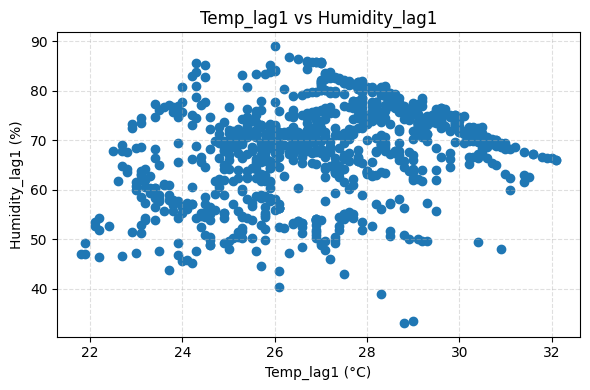

In [41]:
plot_relationship(data=training_data, col1='temp_lag1', col2='humidity_lag1')

In [42]:
x = training_data.drop('humidity',axis=1)
y = training_data['humidity']

In [43]:
x.columns

Index(['temp_lag1', 'humidity_lag1', 'hour'], dtype='object')

In [44]:
train_x, test_x, train_y, test_y = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [45]:
model = RandomForestRegressor()
model.fit(train_x,train_y)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
result_train = model.predict(train_x)

In [47]:
result_test = model.predict(test_x)

In [48]:
print(r2_score(train_y, result_train))

0.9851504858340632


In [49]:
print(r2_score(test_y, result_test))

0.8376507654023821


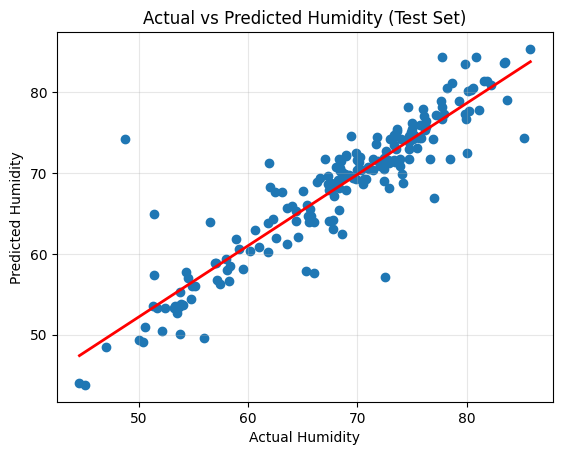

In [50]:
plt.scatter(test_y, result_test)

m, b = np.polyfit(test_y, result_test, 1)   # slope (m) and intercept (b)
x_line = np.linspace(min(test_y), max(test_y), 100)
y_line = m * x_line + b

# Plot the best-fit line
plt.plot(x_line, y_line, linewidth=2, color='red')

plt.xlabel("Actual Humidity")
plt.ylabel("Predicted Humidity")
plt.title("Actual vs Predicted Humidity (Test Set)")
plt.grid(alpha=0.3)
plt.show()

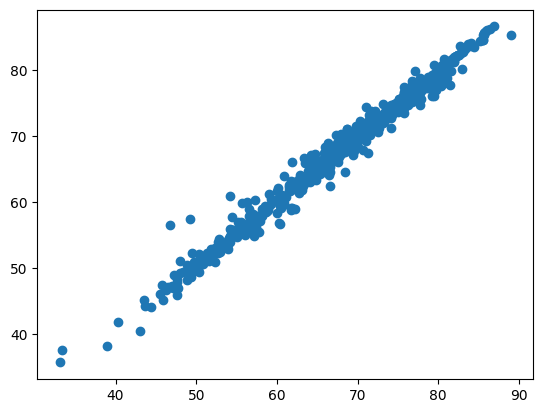

In [51]:
plt.scatter(train_y, result_train)

In [52]:
training_data.head()

,temp_lag1,humidity,humidity_lag1,hour
1,27.0,81.3,81.0,1
2,27.0,81.6,81.3,2
3,27.0,81.8,81.6,3
4,27.0,82.0,81.8,4
5,27.0,82.2,82.0,5


In [53]:
training_data

,temp_lag1,humidity,humidity_lag1,hour
1,27.0,81.3,81.0,1
2,27.0,81.6,81.3,2
3,27.0,81.8,81.6,3
4,27.0,82.0,81.8,4
5,27.0,82.2,82.0,5
...,...,...,...,...
974,26.6,51.3,52.4,7
975,26.6,47.2,51.3,8
976,26.3,43.5,47.2,9
977,26.1,44.6,43.5,10


In [54]:
x.shape

(978, 3)

In [55]:
train_x.shape

(782, 3)

In [56]:
test_x.shape

(196, 3)